In [1]:
import numpy as np
import matplotlib.pyplot as plt

import random
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras.optimizers import Adam
from keras import backend as K

Using TensorFlow backend.


The solution notebook is adapted from: https://keras.io/examples/mnist_siamese/

In [2]:
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

In [3]:
num_classes = 10
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255
x_test = x_test / 255
input_shape = x_train.shape[1:]

# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)

In [4]:
input_shape

(28, 28)

1


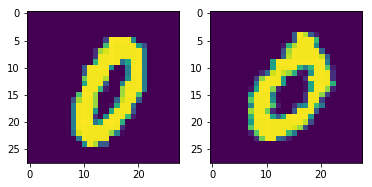

In [5]:
# change index to visualize pairs
# negative (dissimilar) pairs labeled as 0
# positive (similar) pairs labeled as 1
i = 4
print(tr_y[i])

plt.subplot(121)
plt.imshow(tr_pairs[i][0])

plt.subplot(122)
plt.imshow(tr_pairs[i][1])

0


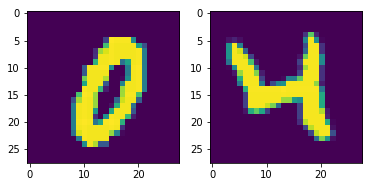

In [6]:
# change index to visualize pairs
# negative (dissimilar) pairs labeled as 0
# positive (similar) pairs labeled as 1
i = 5
print(tr_y[i])

plt.subplot(121)
plt.imshow(tr_pairs[i][0])

plt.subplot(122)
plt.imshow(tr_pairs[i][1])

In [7]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    sqaure_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * sqaure_pred + (1 - y_true) * margin_square)

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [8]:
# build base newtork
def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    return Model(input, x)

In [9]:
# build the complete model
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

In [10]:
# train
opt = Adam()
model.compile(loss=contrastive_loss, optimizer=opt, metrics=[accuracy])
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=3,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

Train on 108400 samples, validate on 17820 samples
Epoch 1/3
108400/108400 [==============================] - 8s 71us/step - loss: 0.1083 - accuracy: 0.8665 - val_loss: 0.0484 - val_accuracy: 0.9453
Epoch 2/3
108400/108400 [==============================] - 7s 62us/step - loss: 0.0475 - accuracy: 0.9505 - val_loss: 0.0339 - val_accuracy: 0.9630
Epoch 3/3
108400/108400 [==============================] - 7s 60us/step - loss: 0.0332 - accuracy: 0.9661 - val_loss: 0.0286 - val_accuracy: 0.9686
